In [366]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from tqdm import tqdm
from scipy.stats import chi2

In [316]:
plt.rcParams.update({'font.size': 15})

In [2]:
filepath = r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\MoonAnalysis\samples"
with open(os.path.join(filepath,'run1_minuit_ArgsErrors.pkl'),'rb') as file:
    M_arr = pickle.load(file)

arr = np.load(os.path.join(filepath,'run1_RecoSigma_N393K.npy'))

In [3]:
arr, M_arr

(array([[ -9.70907239, -11.51647752,   2.09646386],
        [-16.2877784 ,   5.0452761 ,   2.26190127],
        [ -2.23472555,  -2.92543041,   2.26952654],
        ...,
        [-10.68094082,   6.87969587,   2.46466191],
        [  3.19622025,   1.70112561,   2.36013458],
        [-13.89817783,  -1.83021077,   2.34388128]]),
 [{'mu_x': 0.889705190851843,
   'mu_y': 0.7253221842928053,
   'sigma': 0.4752671200232963,
   'f': 0.9999999907718966},
  {'mu_x': 0.7208468302924289,
   'mu_y': 0.6871658559359588,
   'sigma': 0.13984467148045443,
   'f': 0.999704889975459}])

In [4]:
N = 500_000
xw = 20

signal = np.random.uniform(-xw,xw,(N,2))#(np.random.uniform((N,2)) - 0.5)*2*xw
r = np.sqrt(signal[:,0]**2 + signal[:,1]**2)
mask = (r > 0.5)&(r<xw)
signal = signal[mask]

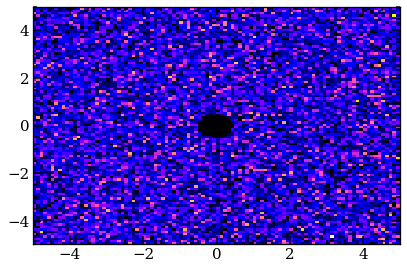

In [5]:
fig, ax = plt.subplots()
lim = 5
ax.hist2d(signal[:,0],signal[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

In [11]:
df = pd.read_csv(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions\Muon_Angle_m21_1b5u_2mio_Muongun_predictions.csv')
def Omega(azp,zep,azt,zet):
    s1 = np.sin( zet + azt - azp )
    s2 = np.sin( zet - azt + azp )
    c1 = np.cos( zet - zep )
    c2 = np.cos( zet + zep )
    return np.arccos(0.5*np.abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2))*180/np.pi

O = Omega(df.azimuth_pred,df.zenith_pred,df.azimuth,df.zenith)
df['solidA'] = O
df['pred_sigma'] *= 180/np.pi
df.head()

Unnamed: 0    event_no   azimuth    zenith  energy_log10  azimuth_pred  \
0           0  11446848.0  2.572490  0.832000    314.890619      2.818875   
1           1  11551037.0  5.056784  0.145751    278.117917      2.710113   
2           2  11630962.0  1.136091  1.079402    239.883669      1.082982   
3           3  11662568.0  5.848608  0.821648    280.400414      5.896593   
4           4  11730720.0  1.293616  1.274554    228.395747      1.320838   

   zenith_pred  pred_sigma     solidA  
0     0.838946   15.623558  10.464781  
1     0.031655    8.791306   9.707213  
2     0.987581    7.316249   5.873786  
3     0.532111   20.995766  16.674842  
4     1.303574   14.061634   2.238098

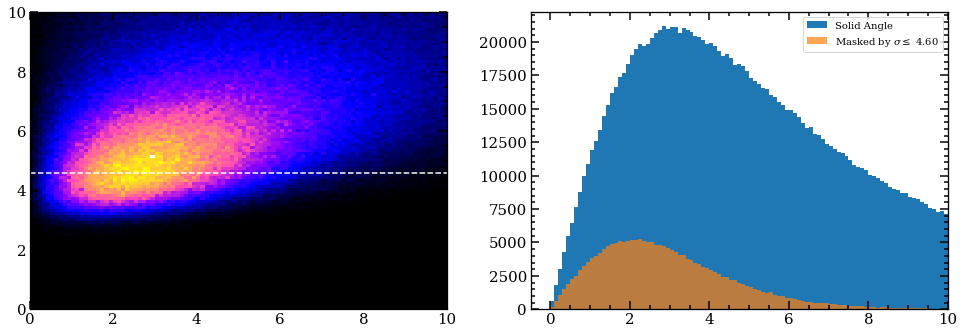

In [13]:
cut = np.quantile(df.pred_sigma,0.1)
O_min, O_max = (0,10)
bins= 100

fig, ax = plt.subplots(figsize=(15,5),ncols=2)
ax[0].hist2d(O,df.pred_sigma,bins=bins,range=((O_min,O_max),(0,10)));
ax[0].hlines(cut,O_min,O_max,color='w',linestyle='--')

ax[1].hist(O,bins=bins,range=(O_min,O_max),label='Solid Angle')
ax[1].hist(O[df.pred_sigma<=cut],bins=bins,range=(O_min,O_max),alpha=0.7,label='Masked by $\sigma \leq$ {:.2f}'.format(cut));
ax[1].set_xlim(ax[1].get_xlim()[0],O_max)
ax[1].legend()

In [15]:
def fan_out(x):
    N = x.shape[0]
    angles = np.random.random(N)*2*np.pi
    tmp = np.zeros((N,2,2))
    sin = np.sin(angles)
    cos = np.cos(angles)
    tmp[:,0,0] = cos
    tmp[:,0,1] = -sin
    tmp[:,1,0] = sin
    tmp[:,1,1] = cos
    xy = np.hstack([x.reshape(N,1),np.zeros((N,1))])
    return np.matmul(xy.reshape(N,1,2),tmp).reshape(N,2)

def sample2d(df2d,N,noise=0):
    return df2d.sample(N,replace=True) + np.random.normal(0,noise,(N,2))

N = signal.shape[0]
reco = signal.copy()
sample = sample2d(df[['solidA','pred_sigma']][df.pred_sigma<=cut],N,noise=0.001)
# print("DOWNSCALING FOR TESTING, SHOULD BE REMOVED IN FINAL REENDITION")
# sample = sample2d(df[['solidA','pred_sigma']][df.pred_sigma<=cut],N,noise=0.001)*0.5
deviation = fan_out(sample.solidA.to_numpy())
reco += deviation

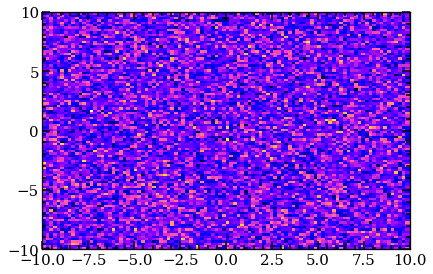

In [18]:
fig, ax = plt.subplots()

lim = 10
ax.hist2d(reco[:,0],reco[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

r = np.sqrt(reco[:,0]**2 + reco[:,1]**2)
vals, binedges = np.histogram(r,bins=10,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = 0.5*(binedges[1:] + binedges[:-1])

In [128]:
lim = 5
bins = 30
vals, binex, biney = np.histogram2d(arr[:,0],arr[:,1],bins=bins,range=((-lim,lim),(-lim,lim)))

In [20]:
def binc(binedges):
    return 0.5*(binedges[1:] + binedges[:-1]), (binedges[1:] - binedges[:-1]).mean()

bincx, dx = binc(binex)
bincy, dy = binc(biney)
X,Y = np.meshgrid(bincx,bincy)
X_grid, Y_grid = np.meshgrid(binex,biney)

In [373]:
shuffled_index = np.arange(arr.shape[0])
np.random.shuffle(shuffled_index)
shuffled_index

array([ 87473, 173206, 296312, ...,  96865, 325998, 280252])

In [374]:
h2 = np.zeros((bincx.shape[0],bincy.shape[0]))
for row, x in enumerate(tqdm(bincx)):
    for col, y in enumerate(bincy):
        r = ((arr[:,0] - x)**2 + (arr[:,1] - y)**2)
#         w = (1+r/dx**2)**(-2)#np.exp(-2/d*r)
        w = np.exp(-(r/(2*(arr[shuffled_index,2])))**2)/(2*np.pi*arr[shuffled_index,2]**2)
        h2[row,col] = w.sum()#(w*df.solidA).sum()/w.sum()

100%|██████████████████████████████████████████| 30/30 [01:14<00:00,  2.50s/it]


In [33]:
h2.max(),vals.max(),h2.min(),vals.min(), ax[[0,1]]

(125.51849554463548,
 55.0,
 114.48683263330543,
 18.0,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB045FD548>,
       dtype=object))

<IPython.core.display.Javascript object>


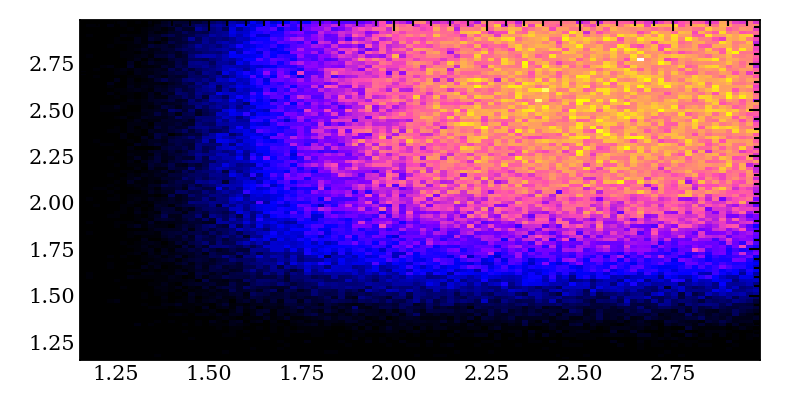

In [382]:
fig, ax = plt.subplots()
ax.hist2d(arr[:,2],arr[shuffled_index,2],bins=100);

In [109]:
str(tmp[0].get_text())

"<Text(0, 0, '')"

In [110]:
# help(tmp[0]), 
tmp[0].set_text("<"+tmp[0].get_text())

In [111]:
tmp

<a list of 7 Text xticklabel objects>

In [117]:
["<"+str(j) if i == 0 else j for i,j in enumerate(tmp)]

['<-4', -2, 0, 2, 4]

[Text(0, 0, '-6'),
 Text(0, 0, '$\\leq$-4'),
 Text(0, 0, '-2'),
 Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '4')]

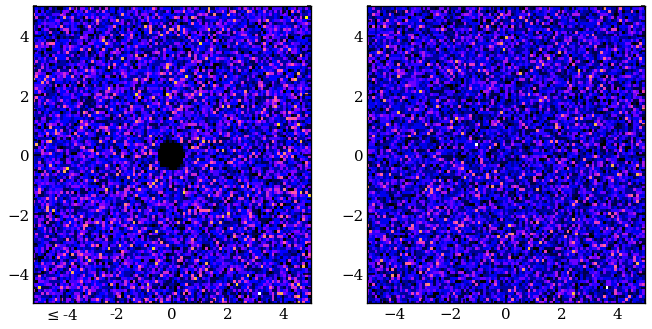

In [120]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
vals1, _, _, im0 = ax[0].hist2d(signal[:,0],signal[:,1],bins=bins,range=((-lim,lim),(-lim,lim)))#,vmin=18,vmax=60);
vals1, _, _, im1 = ax[1].hist2d(arr[:,0],arr[:,1],bins=bins,range=((-lim,lim),(-lim,lim)))#,vmin=18,vmax=60);


# tmp = ax[0].get_xticklabels()
# tmp[0] = "<"+str(tmp[0])
# ax[0].set_xticklabels(["<"+str(j) if i == 0 else j for i,j in enumerate(tmp)])
tmp = np.arange(-6,5,2)
ax[0].set_xticklabels(["$\leq$"+str(j) if i == 1 else str(j) for i,j in enumerate(tmp)])

<IPython.core.display.Javascript object>


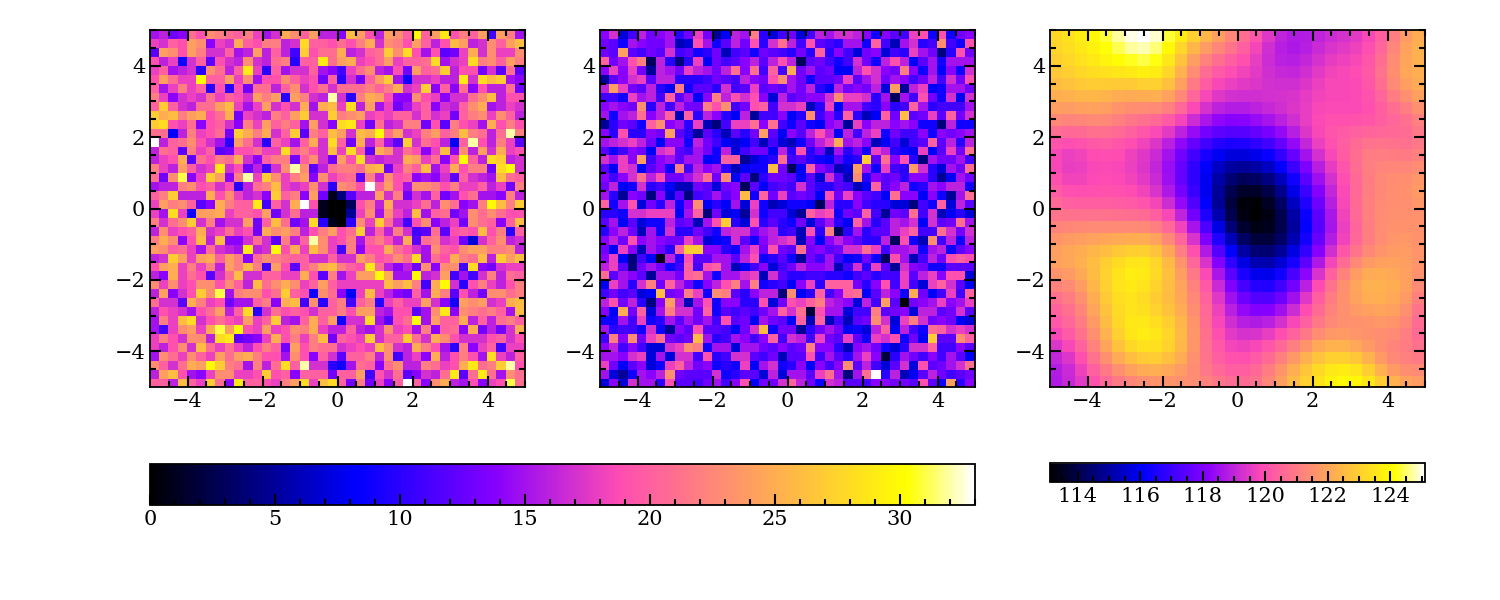

In [375]:
fig, ax = plt.subplots(figsize=(15,6),ncols=3)
vals1, _, _, im0 = ax[0].hist2d(signal[:,0],signal[:,1],bins=bins,range=((-lim,lim),(-lim,lim)))#,vmin=18,vmax=60);
vals1, _, _, im1 = ax[1].hist2d(arr[:,0],arr[:,1],bins=bins,range=((-lim,lim),(-lim,lim)))#,vmin=18,vmax=60);
im2 = ax[2].pcolormesh(X_grid,Y_grid,h2)

cbar1 = fig.colorbar(im0,ax=ax[[0,1]],orientation='horizontal')#,fraction=0.046*5, shrink=1, pad=0.04)
cbar2 = fig.colorbar(im2,ax=ax[2],orientation='horizontal')#,fraction=0.046*0.5,shrink=500, pad=0.04)
# fig.tight_layout()

In [383]:
h = np.zeros((bincx.shape[0],bincy.shape[0]))
scale = dx**2 + dy**2
for col, x in enumerate(tqdm(bincx)):
    for row, y in enumerate(bincy):
        r = ((arr[:,0] - x)**2 + (arr[:,1] - y)**2)
#         w = (1+r/dx**2)**(-2)#np.exp(-2/d*r)
        w = np.exp(-0.5*r/scale)/(2*np.pi*scale**2)
        h[row,col] = w.sum()#(w*df.solidA).sum()/w.sum()

100%|██████████████████████████████████████████| 30/30 [00:32<00:00,  1.07s/it]


<IPython.core.display.Javascript object>


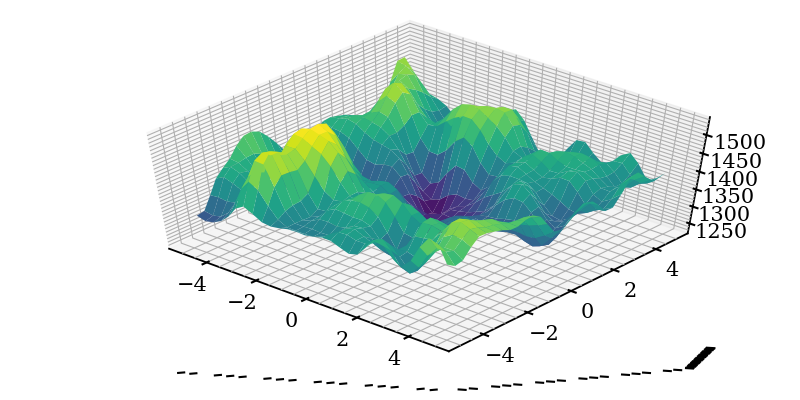

In [384]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(X.flatten(),Y.flatten(),np.zeros(X.flatten().shape[0]),dx,dy,vals.flatten())
ax.plot_surface(X,Y,h,cmap='viridis')

In [169]:
h2 = np.zeros((bincx.shape[0],bincy.shape[0]))
for col, x in enumerate(tqdm(bincx)):
    for row, y in enumerate(bincy):
        r = ((arr[:,0] - x)**2 + (arr[:,1] - y)**2)
#         w = (1+r/dx**2)**(-2)#np.exp(-2/d*r)
        w = np.exp(-0.5*r/arr[:,2]**2)/(2*np.pi*arr[:,2]**2)
        h2[row,col] = w.sum()#(w*df.solidA).sum()/w.sum()

100%|██████████████████████████████████████████| 30/30 [00:18<00:00,  1.59it/s]


In [415]:
scale

0.2222222222222222

<IPython.core.display.Javascript object>


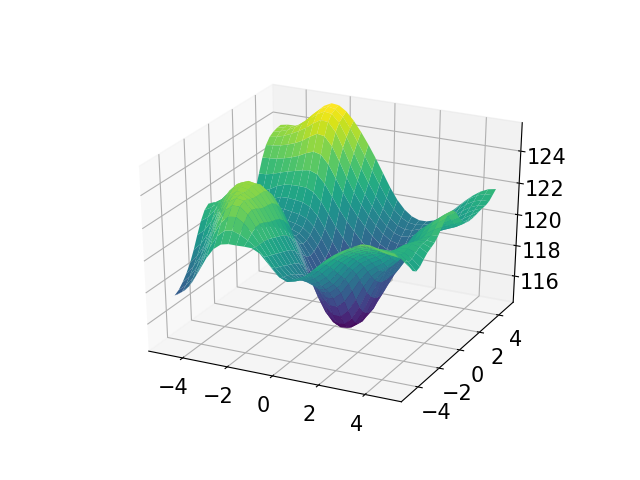

In [360]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(X.flatten(),Y.flatten(),np.zeros(X.flatten().shape[0]),dx,dy,vals.flatten())
ax.plot_surface(X,Y,h2,cmap='viridis')

<IPython.core.display.Javascript object>


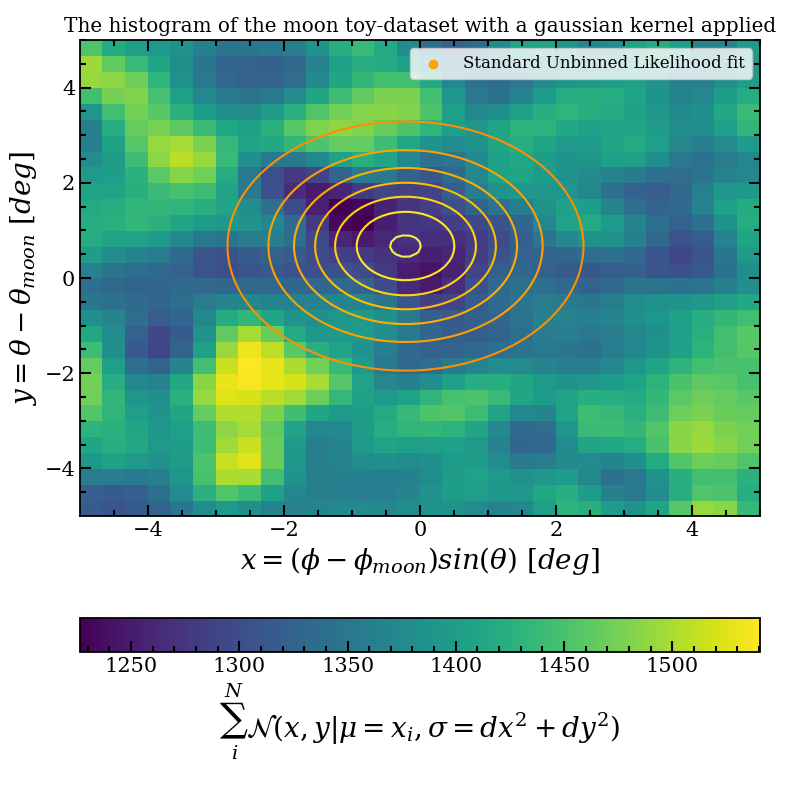

[Text(0, 0.5, '$y=\\theta - \\theta_{moon}$ $[deg]$'),
 Text(0.5, 0, '$x=(\\phi - \\phi_{moon})sin(\\theta)$ $[deg]$'),
 Text(0.5, 1.0, 'The histogram of the moon toy-dataset with a gaussian kernel applied')]

In [409]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.pcolormesh(X_grid, Y_grid, h,cmap='viridis')
cbar = plt.colorbar(im,orientation='horizontal')
cbar.set_label("$\sum_i^N \mathcal{N}(x,y|\mu = x_i,\sigma = dx^2 + dy^2)$")
ax.contour(X_loss,Y_loss,h_loss.reshape(100,100),cmap='Wistia')
ax.scatter(X_loss.flatten()[h_loss.argmin()],Y_loss.flatten()[h_loss.argmin()],color='orange',zorder=-1,label='Standard Unbinned Likelihood fit')

ax.legend()
ax.set(xlabel=r'$x=(\phi - \phi_{moon})sin(\theta)$ $[deg]$',
       ylabel=r'$y=\theta - \theta_{moon}$ $[deg]$',
       title='The histogram of the moon toy-dataset with a gaussian kernel applied')

In [410]:
# fig.savefig("plots/LLH_moon_gaussian_kernel.pdf")

<IPython.core.display.Javascript object>


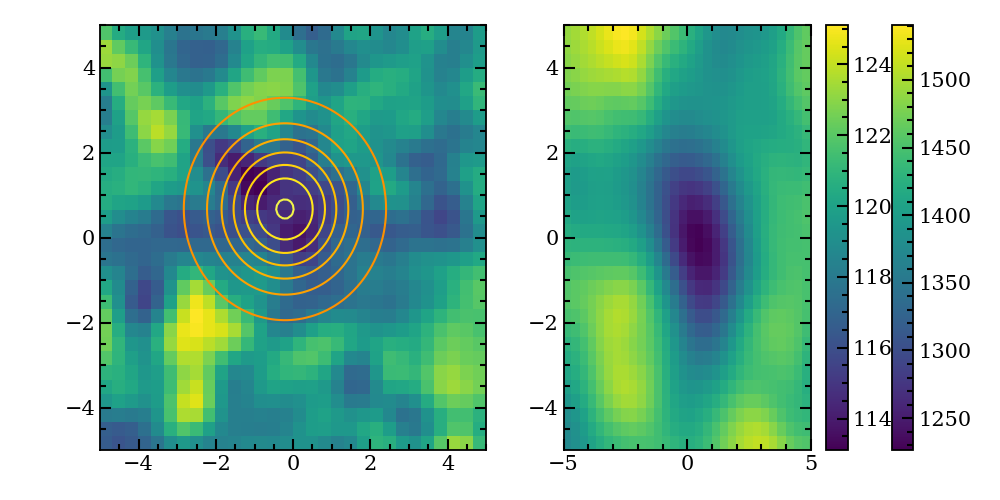

In [390]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
im = ax[0].pcolormesh(X_grid, Y_grid, h,cmap='viridis')
ax[0].contour(X_loss,Y_loss,h_loss.reshape(100,100),cmap='Wistia')
plt.colorbar(im)
im2 = ax[1].pcolormesh(X_grid,Y_grid,h2,cmap='viridis')
plt.colorbar(im2)

<IPython.core.display.Javascript object>


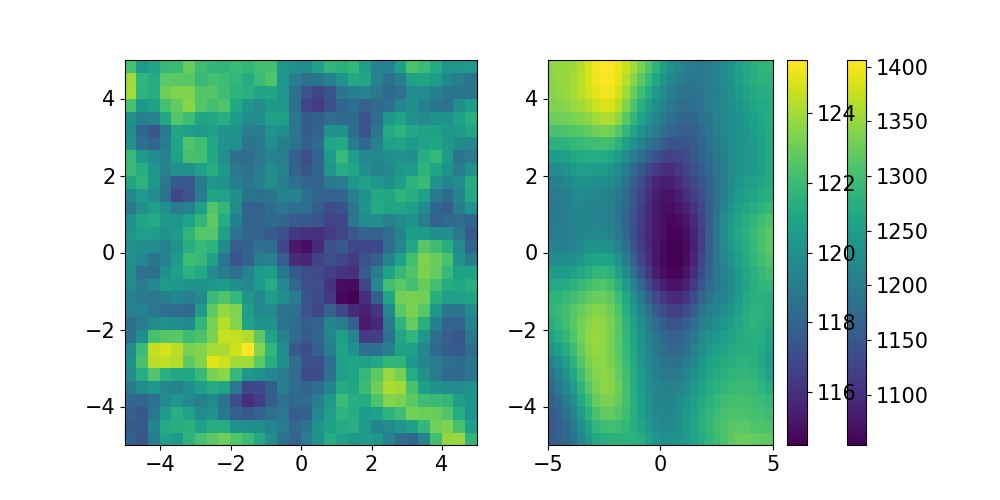

In [362]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
im = ax[0].pcolormesh(X_grid, Y_grid, h)
plt.colorbar(im)
im2 = ax[1].pcolormesh(X_grid,Y_grid,h2)
plt.colorbar(im2)

In [363]:
h2.min()/h2.max(), h.min()/h.max()

(0.9121112560865016, 0.749443637418103)

In [132]:
X_grid.shape, h2.shape

((31, 31), (30, 30))

In [181]:
X_loss, Y_loss = np.meshgrid(np.linspace(-lim,lim,100),np.linspace(-lim,lim,100))

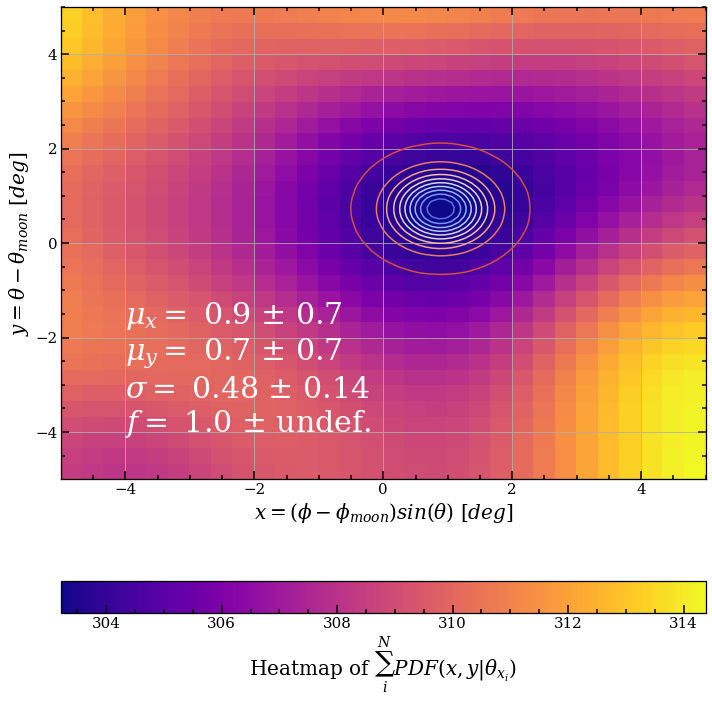

In [245]:
h2_loss = P_2d(X_loss.flatten(),Y_loss.flatten(),*M_arr[0].values())

fig, ax = plt.subplots(figsize=(10,10))
im = ax.pcolormesh(X_grid, Y_grid, h2,cmap='plasma')
# im = ax.pcolormesh(Y_grid.T, X_grid.T, h2)
# _,_,_,im = ax.hist2d(arr[:,0],arr[:,1],bins=20,range=((-4,4),(-4,4)))

# ax.contour(X,Y,h_loss.reshape(bins,bins))
ax.contour(X_loss,Y_loss,h2_loss.reshape(100,100),cmap='coolwarm',levels=10)
# ax.plot(,label='Fit: $\mu_x=$ {}'.format(M_arr[0]['mu_x']))
# ax.legend()

# text = "$\mu_x=$ {:.1f} $\pm$ {:.1f}\
#         \n$\mu_y=$ {:.1f} $\pm$ {:.1f}\
#         \n$\sigma=$ {:.2f} $\pm$ {:.2f}\
#         \n$f=$ {:.1f} $\pm$ {:.1f}".format(M_arr[0]['mu_x'],
#                                                  M_arr[1]['mu_x'],
#                                                  M_arr[0]['mu_y'],
#                                                  M_arr[1]['mu_y'],
#                                                  M_arr[0]['sigma'],
#                                                  M_arr[1]['sigma'],
#                                                  M_arr[0]['f'],
#                                                  M_arr[1]['f'])

text = "$\mu_x=$ {:.1f} $\pm$ {:.1f}\
        \n$\mu_y=$ {:.1f} $\pm$ {:.1f}\
        \n$\sigma=$ {:.2f} $\pm$ {:.2f}\
        \n$f=$ {:.1f} $\pm$ undef.".format(M_arr[0]['mu_x'],
                                                 M_arr[1]['mu_x'],
                                                 M_arr[0]['mu_y'],
                                                 M_arr[1]['mu_y'],
                                                 M_arr[0]['sigma'],
                                                 M_arr[1]['sigma'],
                                                 M_arr[0]['f'])

ax.text(-4,-4,text,color='w',fontsize=30)
ax.grid(zorder=-1)

ax.set(xlabel=r'$x=(\phi - \phi_{moon})sin(\theta)$ $[deg]$',
       ylabel=r'$y=\theta - \theta_{moon}$ $[deg]$')

cbar = plt.colorbar(im,orientation='horizontal')
cbar.set_label(r"Heatmap of $\sum_i^N PDF(x,y|\theta_{x_i})$")
fig.tight_layout()

In [246]:
# fig.savefig("plots/ULLH_moon_result.pdf")

In [220]:
help(cbar.set_label)

Help on method set_label in module matplotlib.colorbar:

set_label(label, **kw) method of matplotlib.colorbar.Colorbar instance
    Label the long axis of the colorbar.



# Fit with unbinned likelihood

In [247]:
from iminuit import Minuit
from scipy.special import erf
class integratedLH:
    def __init__(self, f):
        from iminuit.util import make_func_code
        from iminuit import describe
        self.f = f
        
        self.func_code = make_func_code(describe(self.f))
    
    def __call__(self, *par):
        return self.f(*par)
    
    def default_errordef(self):
        return 0.5

def wrapper(xy_reco, xy_sigma, lim):
    def P_2d(x,y,mu_x,mu_y,sigma,f):
        z_sqrd = ((x-mu_x)**2 + (y - mu_y)**2)/ sigma**2
        norm = 4*lim**2 - 0.5*np.pi*f*sigma**2*(\
                                                (erf((lim + mu_x)/(np.sqrt(2)*sigma)) - erf((-lim + mu_x)/(np.sqrt(2)*sigma)))\
                                                *(erf((lim + mu_y)/(np.sqrt(2)*sigma))-erf((-lim + mu_y)/(np.sqrt(2)*sigma))))
        return (1 - f*np.exp(-0.5*z_sqrd))/norm
    
    def calc_weights():
        x, y = xy_reco[:,0], xy_reco[:,1]
        r = np.sqrt(x**2 + y**2)
        w = np.ones(r.shape[0])
        mask = (x > -lim)&(x < lim)&(y > -lim)&(y < lim)
        w[~mask] = 0
        return w
    
    w = calc_weights()
    try:
        xy_reco = xy_reco[w.astype(bool)]
        xy_sigma = xy_sigma[w.astype(bool)]
    except:
        print("Did not mask")
        pass
    
    def LF2_2d(mu_x,mu_y,sigma,f):
#         def integrand(x_y):
#             x, y = x_y
#             tmp = P_2d(x,y,mu_x,mu_y,sigma,f).T*gauss2d(x,y,xy_reco,xy_sigma).T
#             return tmp
        vals = P_2d(xy_reco[:,0],xy_reco[:,1],mu_x,mu_y,sigma,f)
#         print("HERE!")
        loss = -np.sum(np.log(vals))
        return loss
    return LF2_2d, P_2d, w

In [259]:
LF2_2d, P_2d, w = wrapper(arr[:,:2],arr[:,2],lim)
obj = integratedLH(LF2_2d)
M = Minuit(obj,mu_x=0,mu_y=0,sigma=2,f=1, 
            limit_mu_x=(-lim,lim),limit_mu_y=(-lim,lim),limit_sigma=(0,None),limit_f=(0,1),
            fix_sigma=False,fix_f=False)

In [262]:
M.migrad()

------------------------------------------------------------------
| FCN = 1.419e+05               |     Ncalls=23 (371 total)      |
| EDM = 1.7e-07 (Goal: 0.0001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |   -0.2    |    0.4    |            |            |   -5    |    5    |       |
| 1 | mu_y  |   0.67    |   0.32    |            |            |   -5    |    5    |       |
| 2 | sigma |   1.19    |   0.27    |            |            |    0    |         |       |
| 3 | f     |   0.13    |   0.04    |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

In [347]:
min_mask = h==h.min()
X[min_mask],Y[min_mask]

(array([1.5]), array([-1.16666667]))

In [174]:
M_arr[0].values()

dict_values([0.889705190851843, 0.7253221842928053, 0.4752671200232963, 0.9999999907718966])

In [299]:
10/50

0.2

In [329]:
M.errors['mu_x']

0.424233725020418

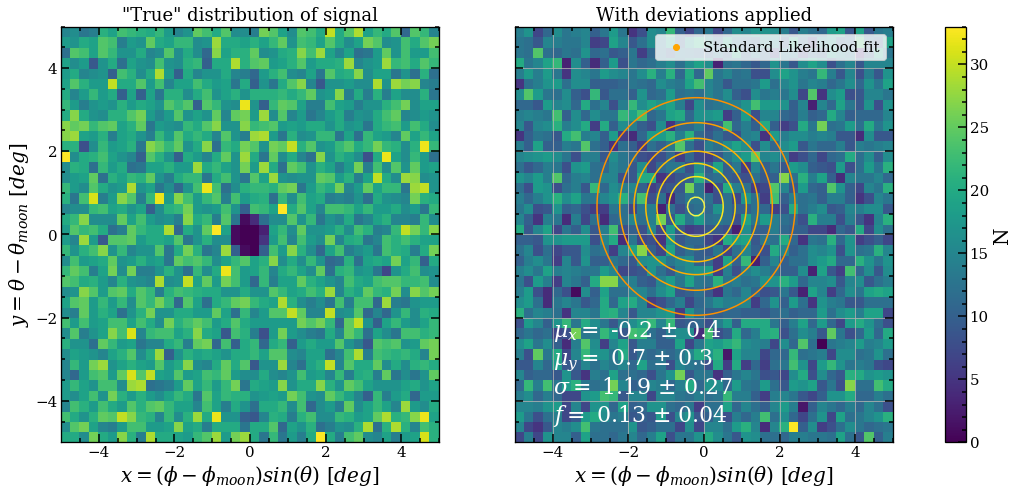

In [359]:
bins = 40
h_loss = P_2d(X_loss.flatten(),Y_loss.flatten(),*M.args)
h2_loss = P_2d(X_loss.flatten(),Y_loss.flatten(),*M_arr[0].values())


fig, ax = plt.subplots(figsize=(17,7),ncols=2,sharex=True,sharey=True)
vals1, _, _, im0 = ax[0].hist2d(signal[:,0],signal[:,1],bins=bins,range=((-lim,lim),(-lim,lim)),cmap='viridis')#,vmin=18,vmax=60);
vals1, _, _, im1 = ax[1].hist2d(arr[:,0],arr[:,1],bins=bins,range=((-lim,lim),(-lim,lim)),cmap='viridis')#,vmin=18,vmax=60);
ax[1].contour(X_loss,Y_loss,h_loss.reshape(100,100),cmap='Wistia')
ax[1].scatter(X_loss.flatten()[h_loss.argmin()],Y_loss.flatten()[h_loss.argmin()],color='orange',zorder=-1,label='Standard Likelihood fit')
# ax[1].contour(X_loss,Y_loss,h2_loss.reshape(100,100),cmap='coolwarm',zorder=1)
ax[1].grid()

cbar = fig.colorbar(im0,ax=ax,orientation='vertical',shrink=1)
cbar.set_label('N')
# fig.tight_layout()


text = "$\mu_x=$ {:.1f} $\pm$ {:.1f}\
        \n$\mu_y=$ {:.1f} $\pm$ {:.1f}\
        \n$\sigma=$ {:.2f} $\pm$ {:.2f}\
        \n$f=$ {:.2f} $\pm$ {:.2f}".format(M.values['mu_x'],
                                                 M.errors['mu_x'],
                                                 M.values['mu_y'],
                                                 M.errors['mu_y'],
                                                 M.values['sigma'],
                                                 M.errors['sigma'],
                                                 M.values['f'],
                                                  M.errors['f'])
ax[1].text(-4,-4.5,text,color='w',fontsize=22)

ax[0].set(xlabel=r'$x=(\phi - \phi_{moon})sin(\theta)$ $[deg]$',
       ylabel=r'$y=\theta - \theta_{moon}$ $[deg]$',
         title='"True" distribution of signal')

ax[1].set(xlabel=r'$x=(\phi - \phi_{moon})sin(\theta)$ $[deg]$',
          title='With deviations applied')

ax[1].legend()

In [360]:
# fig.savefig("plots/LLH_moon_results.pdf")

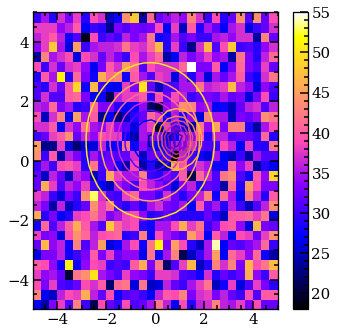

In [261]:
h_loss = P_2d(X_loss.flatten(),Y_loss.flatten(),*M.args)
h2_loss = P_2d(X.flatten(),Y.flatten(),*M_arr[0].values())


fig, ax = plt.subplots(figsize=(5,5))
# im = ax.pcolormesh(X_grid, Y_grid, h)
_,_,_,im = ax.hist2d(arr[:,0],arr[:,1],bins=30,range=((-lim,lim),(-lim,lim)))

ax.contour(X,Y,h_loss.reshape(bins,bins))
ax.contour(X,Y,h2_loss.reshape(bins,bins),cmap='plasma')

plt.colorbar(im)

<IPython.core.display.Javascript object>


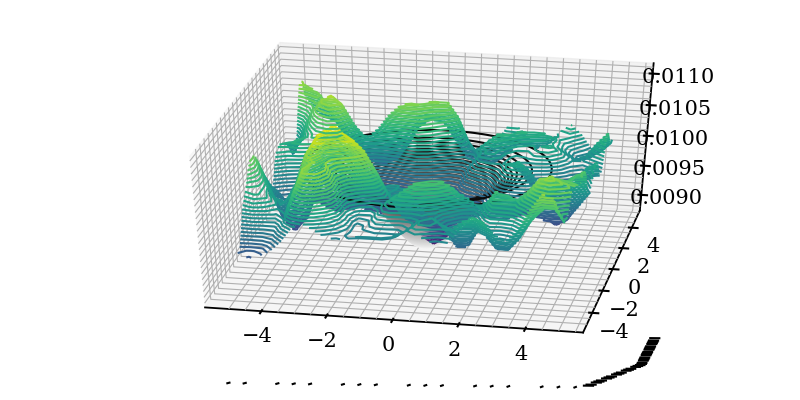

In [389]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, h*h_loss.mean()/h.mean(), 50, cmap='viridis')
# ax.plot_wireframe(X, Y, h*h_loss.mean()/h.mean(), cmap='viridis')
# ax.plot_trisurf(X.flatten(),Y.flatten(),vals.flatten())
ax.contour3D(X_loss, Y_loss, h_loss.reshape(100,100), 50, cmap='binary',alpha=1)
# ax.contour3D(X, Y, h2_loss.reshape(bins,bins), 50, cmap='binary',alpha=1)

In [361]:
import sympy
a = sympy.Symbol('a')
b = sympy.Symbol('b')
s = sympy.Symbol('s')

m = sympy.Symbol('m')
p = sympy.Symbol('p')
c = sympy.Symbol('c')

# N = sympy.Symbol('N')
f = sympy.Symbol('f')
l = sympy.Symbol('l')

expr2 = sympy.sympify("(exp(-((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))*(f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2+l*s^2+c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2+l*s^2+c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))-f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2-l*s^2-c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2+l*s^2+c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))-f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2+l*s^2+c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2-l*s^2-c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))+f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2-l*s^2-c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2-l*s^2-c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))-erf((m+l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+erf((m-l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+erf((m+l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))-erf((m-l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))-c^2*erf((m+l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+c^2*erf((m-l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+c^2*erf((m+l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))-c^2*erf((m-l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))))/(2*(s^2+c^2)*(pi*f*(erf((l+a)/(sqrt(2)*s))+erf((l-a)/(sqrt(2)*s)))*(erf((l+b)/(sqrt(2)*s))+erf((l-b)/(sqrt(2)*s)))*s^2-8*l^2))")
# func = sympy.lambdify((a,b,s,m,p,c,f,l),expr2)
numpy_func = np.vectorize(sympy.lambdify((a,b,s,m,p,c,f,l),expr2))

In [123]:
def wrapper2(xy_reco, xy_sigma, lim, weight_cut=0):
    
    def gauss2d(x,y,mus,sigmas):
        xy = (np.vstack((x,y,)).T).reshape(-1,2,1)
        mus = mus.T.reshape(1,2,-1)
        sigmas = sigmas.reshape(1,-1)
        z_sqrd = (((xy - mus)/sigmas)**2).sum(1)
        return np.exp(-0.5*z_sqrd)/(2*np.pi*sigmas**2)
    
    def P_2d(x,y,mu_x,mu_y,sigma,f):
        z_sqrd = ((x-mu_x)**2 + (y - mu_y)**2)/ sigma**2
        norm = 4*lim**2 - 0.5*np.pi*f*sigma**2*(\
                                                (erf((lim + mu_x)/(np.sqrt(2)*sigma)) - erf((-lim + mu_x)/(np.sqrt(2)*sigma)))\
                                                *(erf((lim + mu_y)/(np.sqrt(2)*sigma))-erf((-lim + mu_y)/(np.sqrt(2)*sigma))))
        return (1 - f*np.exp(-0.5*z_sqrd))/norm
    
    def calc_weights():
        x, y = xy_reco[:,0], xy_reco[:,1]
        r = np.sqrt(x**2 + y**2)
#         w = np.ones(r.shape[0])
        w = 0.5*np.pi*xy_sigma**2*(\
                              (erf((lim + x)/(np.sqrt(2)*xy_sigma)) - erf((-lim + x)/(np.sqrt(2)*xy_sigma)))\
                              *(erf((lim + y)/(np.sqrt(2)*xy_sigma))-erf((-lim + y)/(np.sqrt(2)*xy_sigma))))/(2*np.pi*xy_sigma**2)
        return w
    
    weights = calc_weights()
    
    weight_mask = weights >= weight_cut
    
    xy_reco = xy_reco[weight_mask]
    xy_sigma = xy_sigma[weight_mask]
    unmasked_weights = weights.copy()
    weights = weights[weight_mask]
    
    def LF2_2d(mu_x,mu_y,sigma,f):
        def integrand(x_y):
            x, y = x_y
            tmp = P_2d(x,y,mu_x,mu_y,sigma,f).T*gauss2d(x,y,xy_reco,xy_sigma).T
            return tmp
        vals = numpy_func(mu_x,mu_y,sigma,xy_reco[:,0],xy_reco[:,1],xy_sigma,f,lim)
#         vals = scheme.integrate(integrand,np.array([[[-lim, -lim], [lim, -lim]], [[-lim, lim], [lim, lim]]]))
        loss = -np.sum(weights*np.log(vals))
        fc.Print(loss)
        return loss
    return LF2_2d, P_2d, unmasked_weights

In [364]:
LF2_2d, P_2d, weights = wrapper2(arr[:,:2],arr[:,2],lim,0)

In [362]:
loss2 = numpy_func(M_arr[0]['mu_x'],
           M_arr[0]['mu_y'],
           M_arr[0]['sigma'],
           arr[:,0],
           arr[:,1],
           arr[:,2],
           M_arr[0]['f'],lim)

In [391]:
for cut in np.linspace(np.log(0.1),np.log(1e-6),10):
    mask = weights>np.exp(cut)
    print((weights[mask]*np.log(loss2[mask])).sum() - (np.log(weights[mask]/(4*lim**2))*weights[mask]).sum(),np.exp(cut))

-23.56107273834641 0.10000000000000002
-3.0311027023999486 0.027825594022071253
2.5679830006556585 0.007742636826811269
4.068499938060995 0.0021544346900318843
4.473413416126277 0.0005994842503189415
4.583321524434723 0.00016681005372000594
4.6127913849195465 4.6415888336127784e-05
4.620705490349792 1.2915496650148856e-05
4.622820095391944 3.5938136638046304e-06
4.623365124833072 1.0000000000000004e-06


In [385]:
mask = weights>5e-3
(weights[mask]*np.log(loss2[mask])).sum() - (np.log(weights[mask]/(4*lim**2))*weights[mask]).sum(),(weights[mask]*np.log(loss2[mask])).sum()

(3.3011206876544748, -167457.28788954034)

In [367]:
for cut in [-1,-3,-5,-7,-10,-12,-14,-16]:
    mask = weights>10**(cut)
    nul2 = (np.log(weights[mask]/(4*lim**2))*weights[mask]).sum()
    alt2 = (weights[mask]*np.log(loss2[mask])).sum()
    print(chi2.sf(2*(alt2-nul2),4))

1.0
0.06781685306381748
0.05530972860578255
0.05521188750818252
0.05521120278591093
0.05521120251508125
0.05521120251243899
0.055211202513760126


In [349]:
mask = weights>1e-16
nul2 = (np.log(weights[mask]/(4*lim**2))*weights[mask]).sum()
alt2 = (weights[mask]*np.log(loss2[mask])).sum()

# nul2 = -np.log(4*lim**2)*w.sum()
# alt2 = np.log(P_2d(arr[w.astype(bool),0],arr[w.astype(bool),1],*M_arr[0].values())).sum()

nul = -np.log(4*lim**2)*w.sum()
alt = np.log(P_2d(arr[w.astype(bool),0],arr[w.astype(bool),1],*M.args)).sum()

In [301]:
for ff in np.linspace(0,1,10):
#     print(np.log(P_2d(arr[w.astype(bool),0],arr[w.astype(bool),1],M.values['mu_x'],M.values['mu_y'],M.values['sigma'],ff)).sum()-nul)
    print(np.log(P_2d(arr[w.astype(bool),0],arr[w.astype(bool),1],ff,M.values['mu_y'],M.values['sigma'],M.values['f'])).sum()-nul)

10.30361682275543
10.104969316307688
9.827798123296816
9.476077228813665
9.055027917725965
8.571075092680985
8.03175281145377
7.445559411338763
6.821766694512917
6.170191029028501


In [350]:
alt - nul, alt2 - nul2

(10.455934159370372, 4.623553088487824)

In [351]:
chi2.sf(2*(alt-nul),4), chi2.sf(2*(alt2-nul2),4)

(0.00032966739805915667, 0.055211202513760126)

In [233]:
(weights[mask]*np.log(h_loss[mask])).sum()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 900 but corresponding boolean dimension is 392687

In [231]:
chi2.sf(2*((weights[mask]*np.log(loss2[mask])).sum() - (np.log(weights[mask]/(4*lim**2))*weights[mask]).sum()),4)

0.055211202513760126

In [224]:
np.log(h_loss).sum() + np.log(4*lim**2)*w.sum(), np.log(h2_loss).sum() + np.log(4*lim**2)*w.sum()

(136521.15551431166, 136512.20309867524)

In [193]:
from scipy.stats import chi2
chi2.sf(2*(np.log(h_loss).sum() + np.log(4*lim**2)*w.sum()),4)

0.0

In [232]:
np.log(h_loss).sum(),-np.log(4*lim**2)*w.sum(), (weights[~(weights<1e-16)]*np.log(loss2[~(weights<1e-16)])).sum(), (np.log(weights[mask]/(4*lim**2))*weights[mask]).sum()

(-5400.979277469363,
 -141922.13479178102,
 -168480.28044698274,
 -168484.90400007123)